# LOADING PACKAGES AND DATA

In [1]:
# installing packages
!pip install biopython matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.9 MB/s eta 0:00:00


In [3]:
# loading working directories
from Bio import SeqIO
import os
import gzip
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to working directory
work_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/"
os.chdir(work_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# verifying files against metadata table
import os
import pandas as pd

# Paths
work_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/"
rawseq_dir = os.path.join(work_dir, "rawseq")
sequences_file = os.path.join(work_dir, "sequences.csv")

# 1. Get list of files in rawseq (just filenames, no paths)
if not os.path.exists(rawseq_dir):
    raise FileNotFoundError(f"'rawseq' directory not found: {rawseq_dir}")

files_in_rawseq = set(os.listdir(rawseq_dir))

# 2. Load and filter data from sequences.csv
if not os.path.exists(sequences_file):
    raise FileNotFoundError(f"File 'sequences.csv' not found: {sequences_file}")

df = pd.read_csv(sequences_file)

# Filter out rows where seqResult == "contam"
valid_sequences = df[df["seqResult"] != "contam"]
trace_files_in_csv = set(valid_sequences["traceFileName"].dropna().unique())

# 3. Compare sets
only_in_rawseq = files_in_rawseq - trace_files_in_csv
only_in_csv = trace_files_in_csv - files_in_rawseq

# 4. Display results
print("Files present in rawseq but missing from sequences.csv (excluding 'contam'):")
print(only_in_rawseq)

print("\nFiles present in sequences.csv (excluding 'contam') but missing from rawseq:")
print(only_in_csv)

# Check for perfect match
if not only_in_rawseq and not only_in_csv:
    print("\n✅ All filenames match (after filtering)!")
else:
    print("\n❌ Discrepancies found (see above).")

# (Optional) Save report to file
report = [
    "File comparison report:",
    "---",
    "Files only in rawseq:",
    *only_in_rawseq,
    "",
    "Files only in sequences.csv (excluding 'contam'):",
    *only_in_csv,
    "",
    f"Matching files: {len(files_in_rawseq & trace_files_in_csv)}",
    f"Files only in rawseq: {len(only_in_rawseq)}",
    f"Files only in sequences.csv: {len(only_in_csv)}"
]

with open("file_comparison_report.txt", "w") as f:
    f.write("\n".join(report))

Файлы, которые есть в rawseq, но отсутствуют в sequences.csv (исключая 'contam'):
{'all_sequences_quality.csv'}

Файлы, которые есть в sequences.csv (исключая 'contam'), но отсутствуют в rawseq:
set()

❌ Есть расхождения (см. выше).


# CONVERTING SOURCE FILES AND ANALYZING QUALITY

In [ ]:
# Conversion while preserving full filenames and packing to .gz

import os
import gzip
from Bio import SeqIO

# Set working directory with .ab1 files
work_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/rawseq"
os.chdir(work_dir)  # Change to target directory

print(f"Current directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir()}")

# Convert .ab1 to .fastq.gz
for filename in os.listdir(work_dir):
    if filename.endswith(".ab1"):
        fastq_name = filename.replace(".ab1", ".fastq")
        gz_name = fastq_name + ".gz"
        ab1_path = os.path.join(work_dir, filename)  # Full path to .ab1 file

        print(f"Processing file: {filename}")

        try:
            with gzip.open(gz_name, "wt") as gz_handle:
                for record in SeqIO.parse(ab1_path, "abi"):
                    record.id = filename.replace(".ab1", "")
                    record.description = ""
                    SeqIO.write(record, gz_handle, "fastq")
            print(f"Successfully converted: {filename} → {gz_name}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Verify conversion results
print("\nConversion results:")
fastq_gz_files = [f for f in os.listdir() if f.endswith('.fastq.gz')]
if fastq_gz_files:
    print("Found compressed FASTQ files:")
    for f in fastq_gz_files:
        print(f)
    print("\nFirst file content sample:")
    !zcat {fastq_gz_files[0]} | head -n 4

    # Package for download
    !zip -r converted_fastq_gz.zip *.fastq.gz
    print("\nDownload archive:")
    from google.colab import files
    files.download("converted_fastq_gz.zip")
else:
    print("No .fastq.gz files found. Possible reasons:")
    print("1. No .ab1 files in directory")
    print("2. Conversion errors occurred")
    print(f"Check directory contents: {work_dir}")
    print("Directory contents:")
    !ls -la

In [11]:
# sequence quality assessment
import pandas as pd
from Bio import SeqIO
import gzip
import os

# Path to folder with .fastq.gz files
work_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/rawseq"
os.chdir(work_dir)

# Collect data for ALL reads
all_data = []
for filename in os.listdir():
    if filename.endswith(".fastq.gz"):
        with gzip.open(filename, "rt") as handle:
            for record in SeqIO.parse(handle, "fastq"):
                mean_q = sum(record.letter_annotations["phred_quality"]) / len(record.seq)
                all_data.append({
                    "file": filename,
                    "sequence_id": record.id,
                    "length": len(record.seq),
                    "mean_quality": mean_q
                })

# Create DataFrame
df = pd.DataFrame(all_data)

# Save quality data (separate file)
df.to_csv("all_sequences_quality.csv", index=False)
print("Sequence quality data saved to all_sequences_quality.csv")

# Load metadata
metadata_path = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/sequences.csv"
metadata_df = pd.read_csv(metadata_path)

# Create merge key - remove extensions
df['merge_key'] = df['file'].str.replace('.fastq.gz', '')
metadata_df['merge_key'] = metadata_df['traceFileName'].str.replace('.ab1', '')

# Add quality columns to metadata
for col in ['length', 'mean_quality']:
    if col in metadata_df.columns:
        metadata_df.drop(col, axis=1, inplace=True)  # Remove if already exists

# Merge data
metadata_df = metadata_df.merge(
    df[['merge_key', 'length', 'mean_quality']],
    on='merge_key',
    how='left'
)

# Update seqResult field
metadata_df['seqResult'] = metadata_df.apply(
    lambda row: 'seq failed' if pd.notna(row['mean_quality']) and row['mean_quality'] < 20 else row['seqResult'],
    axis=1
)

# Remove temporary merge_key column
metadata_df.drop('merge_key', axis=1, inplace=True)

# Overwrite original metadata file (first create backup)
backup_path = metadata_path.replace('.csv', '_backup.csv')
metadata_df.to_csv(backup_path, index=False)
print(f"\nMetadata backup created: {backup_path}")

metadata_df.to_csv(metadata_path, index=False)
print(f"Original metadata updated: {metadata_path}")

# Verification
print("\nFirst 5 rows of updated metadata:")
display(metadata_df.head())

Sequence quality data saved to all_sequences_quality.csv

Metadata backup created: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/sequences_backup.csv
Original metadata updated: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/sequences.csv

First 5 rows of updated metadata:


,catNumber,collectionCode,otherCatNumbers,seqNumber,seqResult,traceFileName,region,direction,nameManual,seqManualWorked,seqManual,length,mean_quality
0,05902,YSU-F-,NaN,386,NaN,0005_ITS_F_E03_05_2023_03_24_16_00_37.ab1,ITS,F,Cortinarius disjungendus,DA,>YSU-F-05902 AAGCTGAACTTTTACCCTCACATTCAATAGCGT...,594.0,52.612795
1,06369,YSU-F-,NaN,388,NaN,0005_ITS_F_F03_06_2023_03_24_16_00_37.ab1,ITS,F,Cortinarius heterodepressus,DA,>YSU-F-06369 GAACTGCACCTCACATTCAATAGCATAGATAGT...,588.0,49.792517
2,08374,YSU-F-,NaN,389,NaN,0005_ITS_F_G03_07_2023_03_24_16_00_37.ab1,ITS,F,Cortinarius acutus,DA,>YSU-F-08374 ATATTTATCACACCAATGAGCAGTAAACAAATT...,657.0,48.360731
3,10015,YSU-F-,NaN,393,NaN,0005_ITS_F_H03_08_2023_03_24_16_00_37.ab1,ITS,F,Cortinarius jubarinus,DA,>YSU-F-10015 CACCAATGAGCGGTAAACAAATTGTTTCGCTGA...,647.0,46.952087
4,07554,YSU-F-,NaN,395,NaN,0006_ITS_F_B04_02_2023_03_24_16_00_37.ab1,ITS,F,NaN,NaN,NaN,563.0,28.907638


Quality analysis:   0%|          | 0/957 [00:00<?, ?it/s]

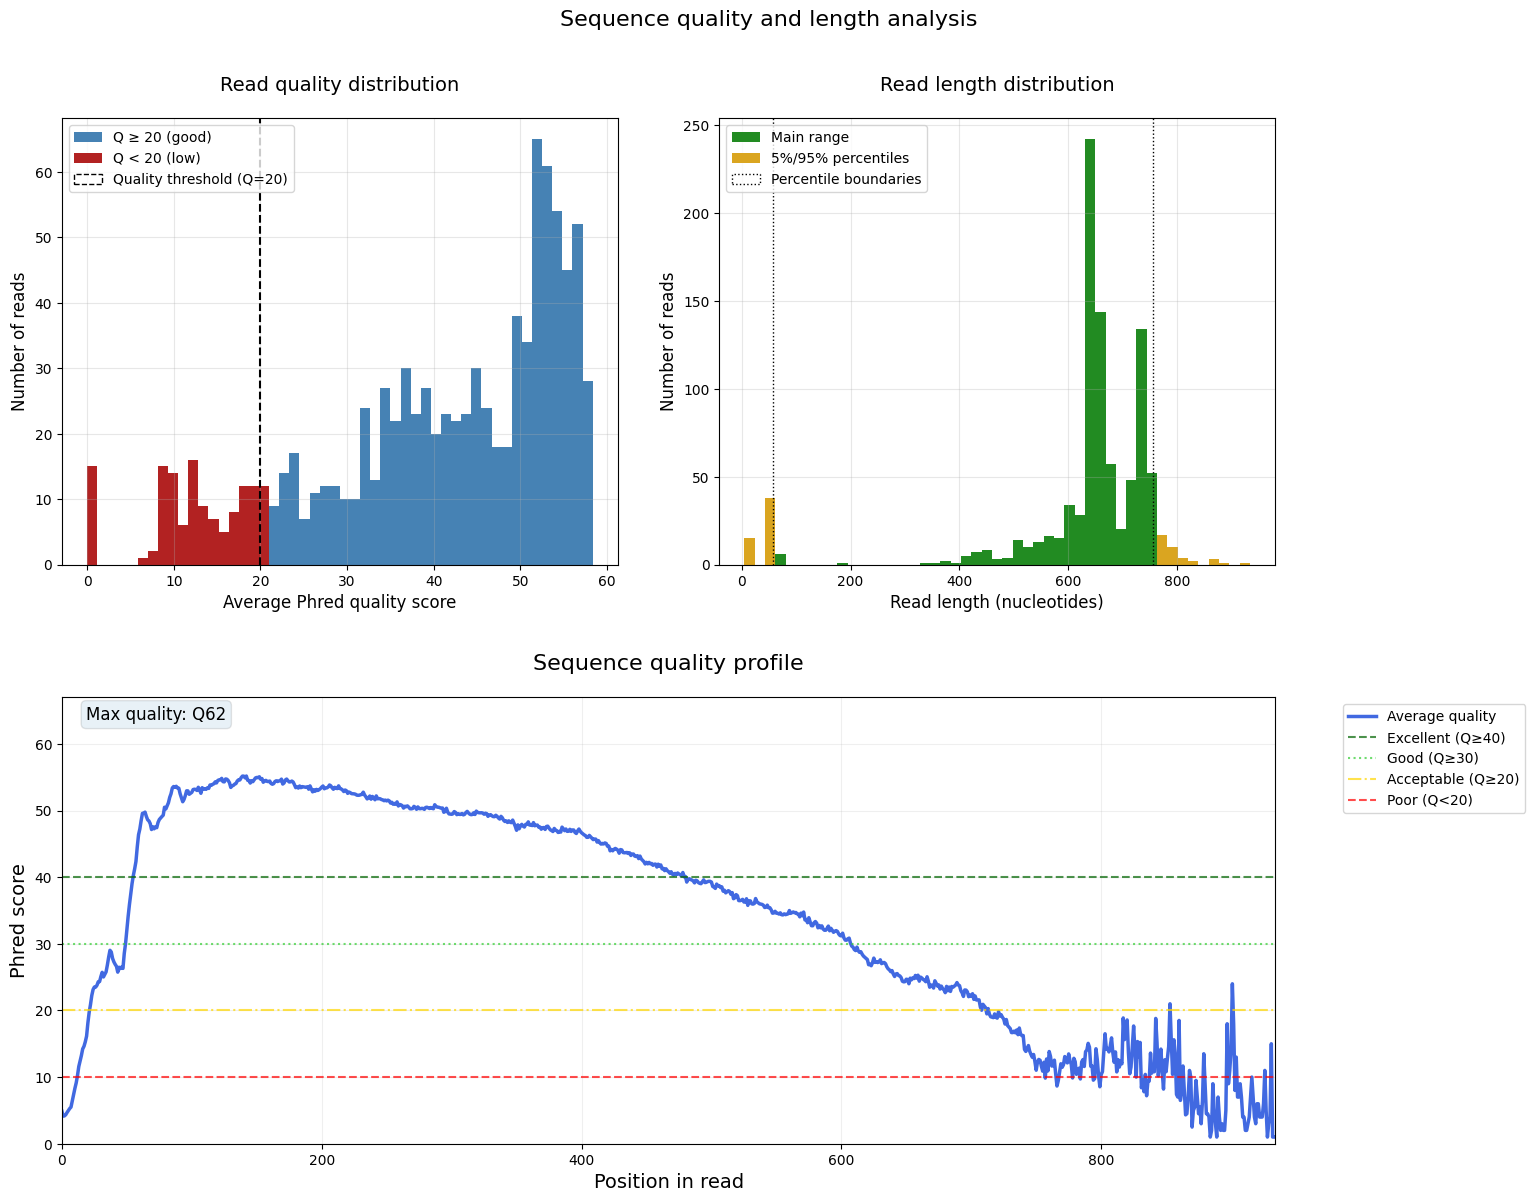


Quality statistics:
• Average quality: 40.1
• Proportion of reads with Q < 20: 12.9%

Length statistics:
• Average length: 623.3 nt
• 5th percentile: 56.8 nt
• 95th percentile: 756.0 nt

Quality profile statistics:
Maximum quality: Q62
Average quality: 34.1
Read length: 934 bp


In [12]:
# visualization of raw sequence quality
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import os
from Bio import SeqIO
import gzip
from tqdm.notebook import tqdm

# Make sure df and low_q_df are defined before use
low_q_df = df[df["mean_quality"] < 20]

# Create a figure with three plot areas
plt.figure(figsize=(16, 12))

# =============================================
# Plot 1: Quality distribution (top left)
# =============================================
plt.subplot(2, 2, 1)

# Quality histogram
n_qual, bins_qual, patches_qual = plt.hist(df["mean_quality"], bins=50, color="steelblue")

# Color bars with Q < 20
for patch, bin_edge in zip(patches_qual, bins_qual):
    if bin_edge < 20:
        patch.set_facecolor('firebrick')
    else:
        patch.set_facecolor('steelblue')

plt.axvline(x=20, color="black", linestyle="--", linewidth=1.5)
plt.xlabel("Average Phred quality score", fontsize=12)
plt.ylabel("Number of reads", fontsize=12)
plt.title("Read quality distribution", fontsize=14, pad=20)
plt.grid(True, alpha=0.3)

# Quality legend
legend_elements_qual = [
    Patch(facecolor='steelblue', label='Q ≥ 20 (good)'),
    Patch(facecolor='firebrick', label='Q < 20 (low)'),
    Patch(facecolor='none', edgecolor='black', linestyle='--',
          label='Quality threshold (Q=20)')
]
plt.legend(handles=legend_elements_qual, fontsize=10)

# =============================================
# Plot 2: Length distribution (top right)
# =============================================
plt.subplot(2, 2, 2)

# Automatic determination of reasonable bins for length
len_bins = np.linspace(df["length"].min(), df["length"].max(), 50)

# Length histogram
n_len, bins_len, patches_len = plt.hist(df["length"], bins=len_bins, color="forestgreen")

# Calculate 5th and 95th percentiles for highlighting
len_5th = df["length"].quantile(0.05)
len_95th = df["length"].quantile(0.95)

# Color outliers
for patch, bin_edge in zip(patches_len, bins_len):
    if bin_edge < len_5th or bin_edge > len_95th:
        patch.set_facecolor('goldenrod')
    else:
        patch.set_facecolor('forestgreen')

plt.axvline(x=len_5th, color="black", linestyle=":", linewidth=1)
plt.axvline(x=len_95th, color="black", linestyle=":", linewidth=1)
plt.xlabel("Read length (nucleotides)", fontsize=12)
plt.ylabel("Number of reads", fontsize=12)
plt.title("Read length distribution", fontsize=14, pad=20)
plt.grid(True, alpha=0.3)

# Length legend
legend_elements_len = [
    Patch(facecolor='forestgreen', label='Main range'),
    Patch(facecolor='goldenrod', label='5%/95% percentiles'),
    Patch(facecolor='none', edgecolor='black', linestyle=':',
          label='Percentile boundaries')
]
plt.legend(handles=legend_elements_len, fontsize=10)

# =============================================
# Plot 3: Quality profile (bottom, full width)
# =============================================
plt.subplot(2, 1, 2)

# Define path to fastq files directory
work_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/rawseq"

# Collect quality data
quality_profiles = []
max_observed_q = 0

for filename in tqdm([f for f in os.listdir(work_dir) if f.endswith(".fastq.gz")],
                   desc="Quality analysis"):
    with gzip.open(os.path.join(work_dir, filename), "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            quals = record.letter_annotations["phred_quality"]
            quality_profiles.append(quals)
            current_max = max(quals)
            if current_max > max_observed_q:
                max_observed_q = current_max

# Define plot parameters
y_max = max(60, max_observed_q + 5)  # Minimum to 60, with +5 margin
x_max = max(len(q) for q in quality_profiles)

# Average by positions (handling different lengths)
avg_quality = []
for pos in range(x_max):
    pos_qualities = [q[pos] for q in quality_profiles if pos < len(q)]
    avg_quality.append(np.mean(pos_qualities) if pos_qualities else np.nan)

# Plotting
plt.plot(avg_quality, color='royalblue', linewidth=2.5, label='Average quality')

# Horizontal threshold lines
thresholds = {
    'Excellent (Q≥40)': {'value': 40, 'color': 'darkgreen', 'linestyle': '--'},
    'Good (Q≥30)': {'value': 30, 'color': 'limegreen', 'linestyle': ':'},
    'Acceptable (Q≥20)': {'value': 20, 'color': 'gold', 'linestyle': '-.'},
    'Poor (Q<20)': {'value': 10, 'color': 'red', 'linestyle': '--'}
}

for label, params in thresholds.items():
    plt.axhline(y=params['value'], color=params['color'],
               linestyle=params['linestyle'], alpha=0.7, label=label)

# Plot settings
plt.title('Sequence quality profile', fontsize=16, pad=20)
plt.xlabel('Position in read', fontsize=14)
plt.ylabel('Phred score', fontsize=14)
plt.ylim(0, y_max)
plt.xlim(0, x_max)

# Legend and grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)

# Add annotation with maximum quality
plt.annotate(f'Max quality: Q{max_observed_q}',
            xy=(0.02, 0.95), xycoords='axes fraction',
            fontsize=12, bbox=dict(boxstyle='round', alpha=0.1))

# =============================================
# General settings
# =============================================
plt.tight_layout(pad=3.0)

# Add main title
plt.suptitle("Sequence quality and length analysis",
             fontsize=16, y=1.02)

plt.show()

# Print statistics
print("\nQuality statistics:")
print(f"• Average quality: {df['mean_quality'].mean():.1f}")
print(f"• Proportion of reads with Q < 20: {len(low_q_df)/len(df)*100:.1f}%")

print("\nLength statistics:")
print(f"• Average length: {df['length'].mean():.1f} nt")
print(f"• 5th percentile: {len_5th:.1f} nt")
print(f"• 95th percentile: {len_95th:.1f} nt")

print(f"\nQuality profile statistics:\nMaximum quality: Q{max_observed_q}\n"
      f"Average quality: {np.nanmean(avg_quality):.1f}\n"
      f"Read length: {x_max} bp")

# SEQUENCE PROCESSING

In [ ]:
# Sequence processing (trimming, assembly) and export of all FASTA files separately and together, and writing sequences to metadata table

import os
import gzip
import shutil
import pandas as pd
import numpy as np
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
from tqdm import tqdm
from google.colab import files as colab_files
from difflib import SequenceMatcher

# ======================
# CONFIGURATION
# ======================
QUALITY_PROFILES = {
    'strict': {
        'min_length': 50,
        'min_avg_quality': 20,
        'min_end_quality': 15,
        'min_overlap': 20,
        'window_size': 5
    },
    'moderate': {
        'min_length': 40,
        'min_avg_quality': 15,
        'min_end_quality': 10,
        'min_overlap': 15,
        'window_size': 5
    },
    'loose': {
        'min_length': 30,
        'min_avg_quality': 10,
        'min_end_quality': 7,
        'min_overlap': 10,
        'window_size': 5
    }
}

CURRENT_PROFILE = QUALITY_PROFILES['strict']

input_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/rawseq"
output_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/"
os.makedirs(output_dir, exist_ok=True)
original_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB"

# ======================
# MAIN FUNCTIONS
# ======================
def load_filtered_metadata(metadata_path):
    """Loads and filters metadata by seqResult"""
    df = pd.read_csv(metadata_path)
    print(f"Total records in metadata: {len(df)}")

def load_filtered_metadata(metadata_path):
    """Loads and filters metadata by seqResult and pcrResult"""
    df = pd.read_csv(metadata_path)
    print(f"Total records in metadata: {len(df)}")

    # Filter by seqResult and pcrResult
    filtered_df = df[
        (~df['seqResult'].isin(['seq failed', 'pcr failed']))
    ]
    print(f"Remaining after filtering: {len(filtered_df)} (excluded seq failed and pcr failed)")

    return filtered_df

def calculate_sequence_quality(sequence):
    """Calculates sequence quality characteristics"""
    if not sequence or not isinstance(sequence, str):
        return {
            'seq_length': 0,
            'n_count': 0,
            'n_percentage': 100.0,
            'quality_score': 0.0
        }

    seq_length = len(sequence)
    n_count = sequence.upper().count('N')
    n_percentage = (n_count / seq_length) * 100 if seq_length > 0 else 100.0
    quality_score = (seq_length * 0.4) - (n_percentage * 0.6)

    return {
        'seq_length': seq_length,
        'n_count': n_count,
        'n_percentage': round(n_percentage, 2),
        'quality_score': round(quality_score, 2)
    }

def process_sanger_read(filepath, params):
    """Processes a read according to quality parameters"""
    try:
        with gzip.open(filepath, 'rt') as f:
            for record in SeqIO.parse(f, 'fastq'):
                quals = record.letter_annotations["phred_quality"]

                # Check average quality
                if np.mean(quals) < params['min_avg_quality']:
                    continue

                # Determine good quality boundaries
                start = next((i for i in range(len(quals)-params['window_size'])
                            if np.mean(quals[i:i+params['window_size']]) >= params['min_end_quality']), 0)
                end = next((i for i in range(len(quals)-1, params['window_size'], -1)
                          if np.mean(quals[i-params['window_size']:i]) >= params['min_end_quality']), len(quals))

                # Trim and check length
                trimmed = record[start:end]
                if len(trimmed) >= params['min_length']:
                    return trimmed
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
    return None

def assemble_contigs(f_read, r_read, sample_id, params):
    """Assembles contigs from forward and reverse reads"""
    try:
        f_seq = str(f_read.seq)
        r_seq = str(r_read.reverse_complement().seq)

        # Sequence alignment
        alignments = pairwise2.align.globalms(
            f_seq, r_seq, 2, -3, -5, -2, one_alignment_only=True
        )

        if not alignments:
            return None

        # Build consensus sequence
        aligned_f, aligned_r = alignments[0][0], alignments[0][1]
        consensus = []
        overlap_len = 0

        for f_base, r_base in zip(aligned_f, aligned_r):
            if f_base == '-' or r_base == '-':
                continue
            overlap_len += 1
            consensus.append(f_base if f_base == r_base else f_base)

        # Check minimum overlap
        if overlap_len >= params['min_overlap']:
            return SeqRecord(
                Seq(''.join(consensus)),
                id=f"contig_{sample_id}",
                description=f"len={len(consensus)}"
            )
    except Exception as e:
        print(f"Assembly error {sample_id}: {str(e)}")
    return None

def process_sample(sample_id, f_files, r_files, params, df_meta):
    """Processes a single sample"""
    # Get manual sequence (if available)
    manual_seq = df_meta[df_meta['catNumber'] == sample_id]['seqManual'].iloc[0] if not df_meta[df_meta['catNumber'] == sample_id].empty else None

    # Get best reads for each direction
    best_f = None
    best_r = None

    for file in f_files:
        read = process_sanger_read(os.path.join(input_dir, file.replace('.ab1', '.fastq.gz')), params)
        if read and (best_f is None or np.mean(read.letter_annotations["phred_quality"]) >
                     np.mean(best_f.letter_annotations["phred_quality"])):
            best_f = read

    for file in r_files:
        read = process_sanger_read(os.path.join(input_dir, file.replace('.ab1', '.fastq.gz')), params)
        if read and (best_r is None or np.mean(read.letter_annotations["phred_quality"]) >
                     np.mean(best_r.letter_annotations["phred_quality"])):
            best_r = read

    # Assemble contig or use single reads
    result = {
        'sample_id': sample_id,
        'result_type': 'failed',
        'auto_sequence': None,
        'identity_percent': None,
        'sequence_preview': None
    }

    if best_f and best_r:
        contig = assemble_contigs(best_f, best_r, sample_id, params)
        if contig:
            result['auto_sequence'] = str(contig.seq)
            result['result_type'] = 'contig'
            SeqIO.write(contig, os.path.join(output_dir, f"{sample_id}_contig.fasta"), "fasta")

    if not result['auto_sequence']:
        if best_f:
            result['auto_sequence'] = str(best_f.seq)
            result['result_type'] = 'F_only'
            SeqIO.write(best_f, os.path.join(output_dir, f"{sample_id}_F.fasta"), "fasta")
        elif best_r:
            result['auto_sequence'] = str(best_r.seq)
            result['result_type'] = 'R_only'
            SeqIO.write(best_r, os.path.join(output_dir, f"{sample_id}_R.fasta"), "fasta")

    # Compare with manual sequence
    if result['auto_sequence'] and manual_seq:
        identity, preview = compare_sequences(result['auto_sequence'], manual_seq)
        result['identity_percent'] = identity
        result['sequence_preview'] = preview

    # Calculate quality metrics
    quality_metrics = calculate_sequence_quality(result['auto_sequence'])
    result.update(quality_metrics)

    return result

def compare_sequences(auto_seq, manual_seq):
    """Compares sequences and calculates identity"""
    if pd.isna(manual_seq) or not manual_seq or not isinstance(manual_seq, str):
        return None, None

    if not auto_seq:
        return 0.0, None

    manual_seq = manual_seq.upper().replace(' ', '').replace('\n', '')
    auto_seq = auto_seq.upper().replace(' ', '').replace('\n', '')

    if not manual_seq or not auto_seq:
        return 0.0, None

    aligner = pairwise2.align.globalxx(auto_seq, manual_seq)
    if not aligner:
        return 0.0, None

    best_aln = aligner[0]
    matches = sum(a == b for a, b in zip(best_aln[0], best_aln[1]))
    identity = matches / max(len(best_aln[0]), len(best_aln[1]))

    preview = f"Auto: {auto_seq[:50]}...\nManual: {manual_seq[:50]}..."
    return round(identity * 100, 2), preview

def main(metadata_path):
    """Main processing function"""
    # Load and filter metadata
    df_meta = load_filtered_metadata(metadata_path)

    # Group files by samples and directions
    samples = defaultdict(lambda: {'F': [], 'R': []})

    for _, row in df_meta.iterrows():
        # Check for direction and catNumber
        if pd.isna(row['direction']) or pd.isna(row['catNumber']):
            print(f"Skipping record with empty direction or catNumber: {row}")
            continue

        try:
            samples[row['catNumber']][row['direction']].append(row['traceFileName'])
        except KeyError as e:
            print(f"Error processing row: {row}")
            print(f"Invalid direction value: {row['direction']}")
            continue

    # Process each sample
    results = []
    all_sequences = []

    for sample_id, files in tqdm(samples.items(), desc="Processing samples"):
        result = process_sample(sample_id, files['F'], files['R'], CURRENT_PROFILE, df_meta)
        results.append(result)

        if result['auto_sequence']:
            record = SeqRecord(
                Seq(result['auto_sequence']),
                id=f"{sample_id}_{result['result_type']}",
                description=f"identity={result['identity_percent']}%"
            )
            all_sequences.append(record)

    # Save results
    save_results(results, all_sequences, df_meta)

def save_results(results, all_sequences, original_meta):
    """Saves all processing results"""
    # Save combined FASTA
    combined_fasta = os.path.join(output_dir, "all_sequences.fasta")
    with open(combined_fasta, "w") as output_handle:
        SeqIO.write(all_sequences, output_handle, "fasta")

    # Create final table
    df_results = pd.DataFrame(results)
    df_final = pd.merge(
        original_meta,
        df_results,
        left_on='catNumber',
        right_on='sample_id',
        how='left'
    )

    # Quality categorization
    df_final['quality_category'] = pd.cut(
        df_final['quality_score'],
        bins=[-float('inf'), 0, 150, 200, 250, float('inf')],
        labels=['Failed', 'Low', 'Medium', 'Good', 'Excellent']
    )

    # Save CSV
    output_csv = os.path.join(output_dir, "comparison_results_with_quality.csv")
    original_output_csv = os.path.join(original_dir, "comparison_results_with_quality.csv")
    df_final.to_csv(output_csv, index=False)
    df_final.to_csv(original_output_csv, index=False)

    # Create archive
    shutil.make_archive("sanger_results", 'zip', output_dir)
    colab_files.download("sanger_results.zip")

    # Print statistics
    print_statistics(df_final)

def print_statistics(df):
    """Prints processing statistics"""
    print("\n=== PROCESSING STATISTICS ===")
    print(f"Total samples: {len(df)}")
    print(f"Successfully assembled contigs: {len(df[df['result_type'] == 'contig'])}")
    print(f"Forward reads only: {len(df[df['result_type'] == 'F_only'])}")
    print(f"Reverse reads only: {len(df[df['result_type'] == 'R_only'])}")
    print(f"Failed to process: {len(df[df['result_type'] == 'failed'])}")

    print("\n=== SEQUENCE QUALITY ===")
    print(f"Average length: {df['seq_length'].mean():.1f} bp")
    print(f"Average N count: {df['n_count'].mean():.1f}")
    print(f"Average N percentage: {df['n_percentage'].mean():.1f}%")
    print("\nQuality category distribution:")
    print(df['quality_category'].value_counts())

    if 'identity_percent' in df.columns:
        valid_comparisons = df['identity_percent'].notna()
        print(f"\nAverage identity with manual data: {df[valid_comparisons]['identity_percent'].mean():.1f}%")

if __name__ == "__main__":
    metadata_path = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/sequences.csv"
    main(metadata_path)

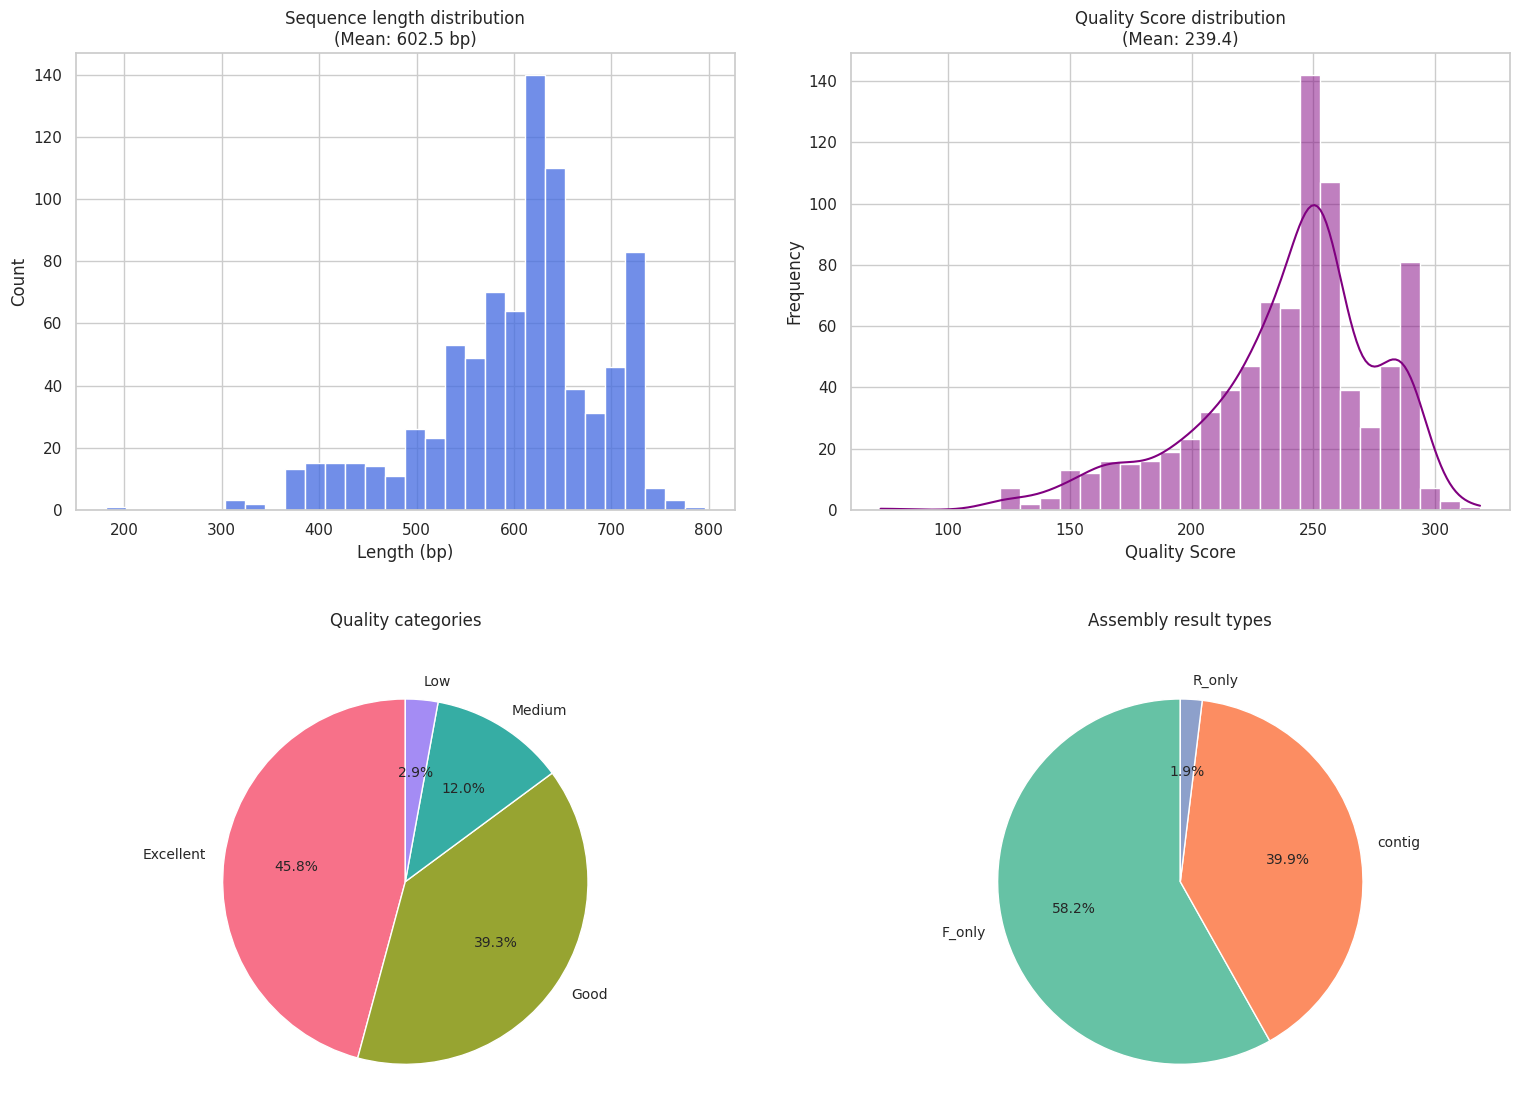


=== QUALITY REPORT ===
Generation time: 2.72 sec
Total samples: 834
--- Key metrics ---
Mean length: 602.5 ± 88.4 bp
Mean N percentage: 2.61% ± 7.95%
Mean Quality Score: 239.42 ± 37.16
--- Category distribution ---
quality_category
Excellent    382
Good         328
Medium       100
Low           24



In [21]:
# visualization of quality for generated FASTA files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

# Configuration
INPUT_CSV = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/comparison_results_with_quality.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/quality_plots/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

start_time = time()

# 1. Load data
df = pd.read_csv(INPUT_CSV, usecols=[
    'seq_length', 'n_percentage',
    'quality_score', 'quality_category',
    'result_type'
])

# 2. Set style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 12))

# --- TOP ROW: HISTOGRAMS ---

# Plot 1: Length distribution
plt.subplot(2, 2, 1)
sns.histplot(df['seq_length'], bins=30, kde=False, color='royalblue')
plt.title(f"Sequence length distribution\n(Mean: {df['seq_length'].mean():.1f} bp)")
plt.xlabel("Length (bp)")
plt.ylabel("Count")

# Plot 2: Quality Score distribution
plt.subplot(2, 2, 2)
sns.histplot(df['quality_score'], bins=30, kde=True, color='purple')
plt.title(f"Quality Score distribution\n(Mean: {df['quality_score'].mean():.1f})")
plt.xlabel("Quality Score")
plt.ylabel("Frequency")

# --- BOTTOM ROW: PIE CHARTS ---

# Plot 3: Quality categories
plt.subplot(2, 2, 3)
quality_counts = df['quality_category'].value_counts()
plt.pie(quality_counts,
        labels=quality_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("husl", len(quality_counts)),
        textprops={'fontsize': 10})
plt.title("Quality categories", pad=20)

# Plot 4: Assembly result types
plt.subplot(2, 2, 4)
if 'result_type' in df.columns:
    result_counts = df['result_type'].value_counts()
    plt.pie(result_counts,
            labels=result_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette("Set2", len(result_counts)),
            textprops={'fontsize': 10})
    plt.title("Assembly result types", pad=20)
else:
    plt.text(0.5, 0.5, 'Assembly type data not available',
             ha='center', va='center', fontsize=10)
    plt.title("Assembly types unavailable", pad=20)

# General settings
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(OUTPUT_DIR, "final_quality_metrics.png"),
            dpi=150, bbox_inches='tight')
plt.show()

# 3. Generate report
execution_time = time() - start_time
stats_report = f"""
=== QUALITY REPORT ===
Generation time: {execution_time:.2f} sec
Total samples: {len(df)}
--- Key metrics ---
Mean length: {df['seq_length'].mean():.1f} ± {df['seq_length'].std():.1f} bp
Mean N percentage: {df['n_percentage'].mean():.2f}% ± {df['n_percentage'].std():.2f}%
Mean Quality Score: {df['quality_score'].mean():.2f} ± {df['quality_score'].std():.2f}
--- Category distribution ---
{df['quality_category'].value_counts().to_string()}
"""

print(stats_report)
with open(os.path.join(OUTPUT_DIR, "quality_report.txt"), 'w') as f:
    f.write(stats_report)

# WORKING WITH BLASTN CLASSIFICATION DATA

In [22]:
# parsing HTML file of BLASTN results from PlutoF|UNITE

import pandas as pd
from bs4 import BeautifulSoup
import os

def parse_blastn_html(html_file_path):
    try:
        with open(html_file_path, 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'html.parser')

        queries = []

        # Find all query blocks
        query_blocks = soup.find_all('div', style=lambda x: x and 'margin-top: 20px' in x)

        for block in query_blocks:
            # Extract query information
            query_text = block.get_text(strip=True)
            if 'Query' in query_text:
                query_num = query_text.split('Query')[1].split('of')[0].strip()
                query_name = query_text.split(':')[1].split('identity=')[0].strip()
            else:
                continue

            # Find the next table after query block
            table = block.find_next('table')
            if not table:
                continue

            hits = []
            # Process table rows (skip header)
            for row in table.find_all('tr')[1:]:
                cols = row.find_all('td')
                if len(cols) >= 13:  # Check if all required columns exist
                    hit = {
                        'Reference': cols[0].get_text(strip=True),
                        'SH:0.5%': cols[1].get_text(strip=True),
                        'SH:1.0%': cols[2].get_text(strip=True),
                        'SH:1.5%': cols[3].get_text(strip=True),
                        'Taxon name': cols[4].get_text(strip=True),
                        'Score': cols[5].get_text(strip=True),
                        'E-value': cols[6].get_text(strip=True),
                        'Prcnt': cols[7].get_text(strip=True),
                        'MisM': cols[8].get_text(strip=True),
                        'Qstart': cols[9].get_text(strip=True),
                        'Qend': cols[10].get_text(strip=True),
                        'Rstart': cols[11].get_text(strip=True),
                        'Rend': cols[12].get_text(strip=True)
                    }
                    hits.append(hit)

            if hits:
                queries.append({
                    'query_num': query_num,
                    'query_name': query_name,
                    'hits': hits
                })

        # Convert to flat table
        rows = []
        for query in queries:
            for hit in query['hits']:
                row = {
                    'Query': query['query_name'],
                    'Reference': hit['Reference'],
                    'SH:0.5%': hit['SH:0.5%'],
                    'SH:1.0%': hit['SH:1.0%'],
                    'SH:1.5%': hit['SH:1.5%'],
                    'Taxon name': hit['Taxon name'],
                    'Score': hit['Score'],
                    'E-value': hit['E-value'],
                    'Prcnt': hit['Prcnt'],
                    'MisM': hit['MisM'],
                    'Qstart': hit['Qstart'],
                    'Qend': hit['Qend'],
                    'Rstart': hit['Rstart'],
                    'Rend': hit['Rend']
                }
                rows.append(row)

        if not rows:
            raise ValueError("No BLAST results found in the file")

        return pd.DataFrame(rows)

    except Exception as e:
        print(f"Error parsing file: {str(e)}")
        raise

# Main execution code
try:
    blast_html_path = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/BlastN.html"
    print(f"Processing file: {blast_html_path}")

    if not os.path.exists(blast_html_path):
        raise FileNotFoundError(f"File not found: {blast_html_path}")

    df = parse_blastn_html(blast_html_path)

    # Save results
    output_csv_path = os.path.join(os.path.dirname(blast_html_path), "blast_results.csv")
    df.to_csv(output_csv_path, index=False)

    print(f"\nSuccessfully processed:")
    print(f"Total queries: {df['Query'].nunique()}")
    print(f"Total results: {len(df)}")
    print(f"CSV saved: {output_csv_path}")

    # Check first rows
    print("\nFirst 3 rows of results:")
    print(df.head(3))

except Exception as e:
    print(f"\nCritical error: {str(e)}")
    print("Recommendations:")
    print("1. Check input file format")
    print("2. Ensure the file contains BLAST results in HTML tables")
    print("3. If problem persists, provide the complete file for analysis")

Processing file: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/BlastN.html

Successfully processed:
Total queries: 615
Total results: 18424
CSV saved: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/blast_results.csv

First 3 rows of results:
          Query Reference         SH:0.5%         SH:1.0%         SH:1.5%  \
0  05902_F_only  PQ641261                                                   
1  05902_F_only  MT935021  SH1888476.10FU  SH1364892.10FU  SH0986152.10FU   
2  05902_F_only  FJ803956  SH1888476.10FU  SH1364892.10FU  SH0986152.10FU   

              Taxon name  Score E-value   Prcnt MisM Qstart Qend Rstart  Rend  
0  Cortinarius distortus  945.8     0.0  100.00    0      4  553   1719  1170  
1  Cortinarius distortus  944.1     0.0   99.82    1      4  554    551     1  
2            Cortinarius  940.6     0.0   99.82    1      4  553    550     1  


In [ ]:
# Downloading Cortinarius type specimens from NCBI

from Bio import Entrez
import time
import pandas as pd
from urllib.error import HTTPError

Entrez.email = "filippova.courlee.nina@gmail.com"  # Critical to provide a real email
NCBI_DELAY = 3  # Delay between requests (seconds)
MAX_RETRIES = 5  # Maximum number of retry attempts

def safe_entrez_request(func, *args, **kwargs):
    """Wrapper for Entrez requests with retries on errors"""
    for attempt in range(MAX_RETRIES):
        try:
            time.sleep(NCBI_DELAY)
            return func(*args, **kwargs)
        except HTTPError as e:
            if e.code == 429:
                wait = (attempt + 1) * 10  # Increase delay
                print(f"Too many requests. Waiting {wait} sec...")
                time.sleep(wait)
            else:
                raise
    raise Exception(f"Failed to complete request after {MAX_RETRIES} attempts")

# 1. Search for Cortinarius type specimens
try:
    print("Searching for type sequences...")
    handle = safe_entrez_request(
        Entrez.esearch,
        db="nucleotide",
        term='"Cortinarius"[Organism] AND "type material"[Filter]',
        retmax=1000,
        usehistory="y"
    )
    search_results = Entrez.read(handle)
    handle.close()

    # Get IDs through History (for large datasets)
    webenv = search_results["WebEnv"]
    query_key = search_results["QueryKey"]
    count = int(search_results["Count"])
    print(f"Found {count} type specimens")

    # 2. Retrieve metadata in batches
    batch_size = 100
    all_records = []

    for start in range(0, count, batch_size):
        print(f"Processing records {start+1}-{min(start+batch_size, count)}")

        handle = safe_entrez_request(
            Entrez.efetch,
            db="nucleotide",
            rettype="gb",
            retmode="xml",
            retstart=start,
            retmax=batch_size,
            webenv=webenv,
            query_key=query_key
        )
        records = Entrez.read(handle)
        all_records.extend(records)
        handle.close()

    # 3. Extract accession numbers
    type_accessions = []
    for record in all_records:
        acc = record['GBSeq_primary-accession']
        organism = record['GBSeq_organism']

        # Verify type material status
        is_type = False
        for feature in record.get('GBSeq_feature-table', []):
            if feature.get('GBFeature_key') == 'source':
                for qual in feature.get('GBFeature_quals', []):
                    if qual.get('GBQualifier_name') == 'type_material':
                        is_type = True
                        break

        if is_type:
            type_accessions.append(acc)
            print(f"{acc}: {organism} (TYPE)")

    # 4. Save results
    df = pd.DataFrame({'Accession': type_accessions})
    df.to_csv('Cortinarius_type_materials.csv', index=False)
    print(f"\nSaved {len(type_accessions)} type accession numbers to Cortinarius_type_materials.csv")

except Exception as e:
    print(f"Error: {str(e)}")

In [24]:
# selecting best identification (best hit) with priority: type specimen > best score
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict

# ======================
# CONFIGURATION
# ======================
INPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/blast_results.csv"
TYPES_DB_PATH = "Cortinarius_type_materials.csv"
SKIP_PREFIXES = ['UDB', 'MZ', 'KU', 'HQ', 'KM', 'MT', 'MH', 'DQ']

# ======================
# FUNCTIONS
# ======================
def load_type_database():
    """Loads the type specimen database and returns a set"""
    type_db = pd.read_csv(TYPES_DB_PATH)
    return set(type_db['Accession'].astype(str).str.strip().values)

def is_species_level(taxon_name):
    """Checks if the taxon is a binomial name (species level)"""
    if pd.isna(taxon_name):
        return False
    parts = str(taxon_name).strip().split()
    return len(parts) >= 2 and parts[1] not in ['sp.', 'sp', 'cf.', 'aff.']

def select_best_hits(df):
    """
    Selects best hits for each Query with priority:
    1. Type specimens identified to species level
    2. Maximum Score among species-level identifications
    """
    # Filter only species-level identifications
    species_hits = df[df['Taxon name'].apply(is_species_level)].copy()

    # Sort by priorities
    species_hits.sort_values(['Query', 'is_type', 'Score'],
                           ascending=[True, False, False], inplace=True)

    # Select best hit for each Query
    best_hits = species_hits.groupby('Query').first().reset_index()

    # Add list of all unique species taxa for each Query
    unique_taxa = species_hits.groupby('Query')['Taxon name'].unique().apply(
        lambda x: '|'.join(sorted(set(x), key=str)))
    best_hits['All_Taxa'] = best_hits['Query'].map(unique_taxa)

    return best_hits

# ======================
# MAIN BLOCK
# ======================
def main():
    try:
        # 1. Load BLAST data
        print("Loading BLAST data...")
        blast_df = pd.read_csv(INPUT_PATH)
        print(f"Loaded rows: {len(blast_df)}")

        # 2. Load type specimen database
        print("Loading type specimen database...")
        type_accessions = load_type_database()
        print(f"Loaded {len(type_accessions)} type sequences")

        # 3. Filter problematic accessions
        blast_df = blast_df[~blast_df['Reference'].astype(str).str.startswith(tuple(SKIP_PREFIXES))]
        print(f"Remaining after filtering: {len(blast_df)}")

        # 4. Add type specimen markers
        blast_df['is_type'] = blast_df['Reference'].astype(str).isin(type_accessions)

        # 5. Select best hits (only species-level identifications)
        print("Selecting best hits (species-level only)...")
        best_hits_df = select_best_hits(blast_df)

        # 6. Save results
        output_path = INPUT_PATH.replace(".csv", "_best_species_hits.csv")
        best_hits_df.to_csv(output_path, index=False)

        # 7. Statistics
        print("\n" + "="*50)
        print("FINAL RESULTS")
        print(f"Total queries: {len(best_hits_df)}")
        print(f"Type specimens found: {best_hits_df['is_type'].sum()}")
        print(f"Unique species: {best_hits_df['All_Taxa'].nunique()}")
        print(f"Saved to: {output_path}")
        print("="*50)

        # Example type specimens
        type_samples = best_hits_df[best_hits_df['is_type']].head(3)
        if not type_samples.empty:
            print("\nExample type specimens (identified to species level):")
            print(type_samples[['Query', 'Reference', 'Taxon name', 'Score']])

    except Exception as e:
        print(f"\n!!! CRITICAL ERROR: {str(e)}")

if __name__ == "__main__":
    main()

Loading BLAST data...
Loaded rows: 18424
Loading type specimen database...
Loaded 1901 type sequences
Remaining after filtering: 11585
Selecting best hits (species-level only)...

FINAL RESULTS
Total queries: 605
Type specimens found: 115
Unique species: 315
Saved to: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/blast_results_best_species_hits.csv

Example type specimens (identified to species level):
           Query Reference                  Taxon name   Score
1   00970_F_only  JN114084       Cortinarius purpureus  1007.6
11  01080_F_only  JN114087  Cortinarius pseudofervidus   851.4
12  01081_contig  KP087988   Cortinarius uliginobtusus  1023.1


In [29]:
# merging best hits with original sequence table

import pandas as pd
import os

# Load data
output_dir = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB"  # Replace with your path
blast_best_path = os.path.join(output_dir, "blast_results_best_species_hits.csv")
comparison_path = os.path.join(output_dir, "comparison_results_with_quality.csv")

# 1. Process blast_best_hits.csv - create catNumber
blast_df = pd.read_csv(blast_best_path)

# Extract catNumber from Query (everything before first underscore)
blast_df['catNumber'] = blast_df['Query'].str.split('_').str[0]

# Convert to string to preserve zeros
blast_df['catNumber'] = blast_df['catNumber'].astype(str)

# 2. Load comparison_results.csv
comparison_df = pd.read_csv(comparison_path)

# Pad numbers with zeros to match blast_df format (5 digits)
comparison_df['catNumber'] = comparison_df['catNumber'].astype(str).str.zfill(5)

# Check
print("Unique catNumbers in blast_best_hits:")
print(blast_df['catNumber'].unique()[:10])  # Show first 10 for verification

print("\nUnique catNumbers in comparison_results:")
print(comparison_df['catNumber'].unique()[:10])

# 3. Merge tables
# Left join to keep all rows from comparison_results
merged_df = pd.merge(
    comparison_df,
    blast_df,
    on='catNumber',
    how='left',
    suffixes=('', '_blast')
)

# 4. Save result
merged_path = os.path.join(output_dir, "final_merged_results.csv")
merged_df.to_csv(merged_path, index=False)

print(f"\nMerge completed. Result saved to: {merged_path}")
print(f"Original sizes: comparison_results - {comparison_df.shape}, blast_best_hits - {blast_df.shape}")
print(f"Final size: {merged_df.shape}")

Unique catNumbers in blast_best_hits:
['00969' '00970' '01067' '01068' '01069' '01071' '01073' '01074' '01075'
 '01076']

Unique catNumbers in comparison_results:
['05902' '06369' '08374' '10015' '07554' '10985' '01068' '01069' '12594'
 '12598']

Merge completed. Result saved to: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/final_merged_results.csv
Original sizes: comparison_results - (834, 23), blast_best_hits - (605, 17)
Final size: (834, 39)


In [33]:
# comparison of automated vs manual identification

import pandas as pd
import re
from difflib import SequenceMatcher
from tqdm import tqdm

# Path settings
INPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/final_merged_results.csv"
OUTPUT_PATH = INPUT_PATH.replace(".csv", "_with_comparison_final_v2.csv")

def normalize_name(name):
    """Normalize taxon names (remove genus and endings)"""
    if pd.isna(name):
        return ''
    name = str(name).lower().strip()
    name = re.sub(r'\s+', ' ', name)
    name = re.sub(r'[^a-z ]', '', name)
    return name

def extract_species(name):
    """Extract species epithet (second word)"""
    if pd.isna(name):
        return ''
    parts = str(name).split()
    return parts[1] if len(parts) > 1 else ''

def compare_species(manual, auto):
    """Compare species epithets with normalization"""
    manual_species = extract_species(manual)
    auto_species = extract_species(auto)

    if not manual_species or not auto_species:
        return 0

    # Remove endings (us, a, um etc.)
    manual_stem = re.sub(r'(us|a|um|is|es|i|ae|orum)$', '', normalize_name(manual_species))
    auto_stem = re.sub(r'(us|a|um|is|es|i|ae|orum)$', '', normalize_name(auto_species))

    return 1 if (
        manual_stem == auto_stem or
        manual_stem in auto_stem or
        auto_stem in manual_stem or
        SequenceMatcher(None, manual_stem, auto_stem).ratio() > 0.85
    ) else 0

def process_taxon_name(row):
    """Process taxon name based on Prcnt value"""
    if pd.isna(row['Taxon name']):
        return pd.Series(['', ''])

    prcnt = float(row['Prcnt']) if not pd.isna(row['Prcnt']) else 0
    taxon = str(row['Taxon name']).strip()

    if prcnt >= 97:
        return pd.Series(['', taxon])  # No qualifier, full name
    elif prcnt >= 95:
        return pd.Series(['aff.', taxon])  # Add 'aff.' qualifier
    else:
        # Keep only genus name
        genus = taxon.split()[0] if len(taxon.split()) > 0 else taxon
        return pd.Series(['', genus])  # No qualifier, genus only

def main():
    # Load data
    print("Loading data...")
    df = pd.read_csv(INPUT_PATH)

    # Remove specified columns
    columns_to_drop = ['sample_id', 'sequence_preview', 'Query', 'Qstart', 'Qend', 'Rstart', 'Rend']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Ensure Prcnt is numeric
    df['Prcnt'] = pd.to_numeric(df['Prcnt'], errors='coerce')

    # Process taxon names based on Prcnt values
    print("Processing taxon names based on percentage identity...")
    df[['qualifier', 'curatedBestHitTaxon']] = df.apply(process_taxon_name, axis=1)

    # Unique samples with manual identification
    manual_samples = df[df['nameManual'].notna()].drop_duplicates('catNumber')
    print(f"Unique samples with manual ID: {len(manual_samples)}")

    # Comparison only for unique catNumber
    comparison_results = {}
    for _, row in tqdm(manual_samples.iterrows(), total=len(manual_samples), desc="Comparing"):
        manual_id = row['nameManual']
        auto_id = row['Taxon name'] if not pd.isna(row['Taxon name']) else ''
        comparison_results[row['catNumber']] = compare_species(manual_id, auto_id)

    # Add results to original DataFrame
    df['identification_match'] = df['catNumber'].map(comparison_results)

    # Save results
    df.to_csv(OUTPUT_PATH, index=False)
    print(f"\nResults saved to: {OUTPUT_PATH}")

    # Statistics for UNIQUE samples
    total = len(comparison_results)
    matches = sum(comparison_results.values())

    print("\nFinal statistics (unique samples):")
    print(f"Total samples: {total}")
    print(f"Matches: {matches} ({matches/total:.1%})")
    print(f"Discrepancies: {total - matches} ({(total - matches)/total:.1%})")

    # Example discrepancies
    discrepancies = [k for k, v in comparison_results.items() if v == 0]
    if discrepancies:
        print("\nExample discrepancies (first 3):")
        for cat in discrepancies[:3]:
            sample = manual_samples[manual_samples['catNumber'] == cat].iloc[0]
            print(f"catNumber: {cat}")
            print(f"Manual ID: {sample['nameManual']}")
            print(f"Auto ID: {sample['Taxon name']}")
            print(f"Curated ID: {sample['qualifier']} {sample['curatedBestHitTaxon']}")
            print(f"Compared: '{extract_species(sample['nameManual'])}' vs '{extract_species(sample['Taxon name'])}'\n")

if __name__ == "__main__":
    main()

Loading data...
Processing taxon names based on percentage identity...
Unique samples with manual ID: 516


Comparing: 100%|██████████| 516/516 [00:00<00:00, 8117.61it/s]


Results saved to: /content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/final_merged_results_with_comparison_final_v2.csv

Final statistics (unique samples):
Total samples: 516
Matches: 327 (63.4%)
Discrepancies: 189 (36.6%)

Example discrepancies (first 3):
catNumber: 5902
Manual ID: Cortinarius disjungendus
Auto ID: Cortinarius distortus
Curated ID:  Cortinarius distortus
Compared: 'disjungendus' vs 'distortus'

catNumber: 10015
Manual ID: Cortinarius jubarinus
Auto ID: Cortinarius scoticus
Curated ID: aff. Cortinarius scoticus
Compared: 'jubarinus' vs 'scoticus'

catNumber: 12598
Manual ID: Cortinarius coleoptera
Auto ID: Cortinarius umbrinolens
Curated ID:  Cortinarius umbrinolens
Compared: 'coleoptera' vs 'umbrinolens'



# OTHER ANALYSES

In [ ]:
# loading ID numbers from NCBI database for submission to ENA

from Bio import Entrez
import pandas as pd
import time  # Added time module import
from tqdm.notebook import tqdm

# --- Settings ---
Entrez.email = "filippova.courlee.nina@gmail.com"  # Must replace with a real email!
API_DELAY = 0.34  # Delay between requests (in seconds)

# --- Table validation ---
if not isinstance(taxa, pd.DataFrame):
    raise ValueError("'taxa' must be a pandas DataFrame!")
if 'name' not in taxa.columns:
    raise ValueError("Table 'taxa' must contain a 'name' column!")

# --- Function for tax_id query with error handling ---
def get_taxid(species_name):
    try:
        handle = Entrez.esearch(db="taxonomy", term=species_name, retmode="xml")
        record = Entrez.read(handle)
        handle.close()
        return record["IdList"][0] if record["IdList"] else pd.NA
    except Exception as e:
        print(f"Error for '{species_name}': {str(e)}")
        return pd.NA

# --- Progress bar and processing ---
tqdm.pandas(desc="Querying tax_id from NCBI")

# Apply function with delay
taxa['tax_id'] = taxa['name'].progress_apply(
    lambda x: (time.sleep(API_DELAY), get_taxid(x))[1]
)

# --- Results ---
print("\nResults:")
print(f"Found tax_id: {taxa['tax_id'].notna().sum()}/{len(taxa)}")
display(taxa.head())

# --- Saving ---
output_filename = "taxa_with_taxids.csv"
taxa.to_csv(output_filename, index=False)
print(f"\nResults saved to file: {output_filename}")

# For Google Colab (if download needed)
try:
    from google.colab import files
    files.download(output_filename)
except ImportError:
    pass

In [ ]:
# small geographic analysis
import pandas as pd
import numpy as np
import os
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle

# Load data
# Specify the correct path to your working directory
work_dir = '/content/drive/MyDrive/Colab Notebooks/IT_expedition/CortDB/'  # For Google Colab typically /content/
file_name = "geography1.csv"  # Make sure the filename is correct (possible typo "gepgraphy" instead of "geography")

# Full file path
file_path = os.path.join(work_dir, file_name)

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Please check the path and filename.")

# Read data
df = pd.read_csv(file_path)

# Check for required columns
required_columns = ['decimalLatitude', 'decimalLongitude', 'sample_id']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Required column missing: {col}")

# Convert coordinates to radians for calculations
coords = np.radians(df[['decimalLatitude', 'decimalLongitude']].values)

# DBSCAN parameters
epsilon = 5 / 6371.0088  # 5 km in radians (6371.0088 - Earth radius in km)
min_samples = 1  # Minimum 1 point per cluster

# Create DBSCAN model
db = DBSCAN(eps=epsilon, min_samples=min_samples, metric='haversine', algorithm='ball_tree')
labels = db.fit_predict(coords)

# Add cluster labels to DataFrame
df['cluster'] = labels

# Function to find cluster center
def get_center(cluster_df):
    return (cluster_df['decimalLatitude'].mean(), cluster_df['decimalLongitude'].mean())

# Create DataFrame with cluster information
clusters_info = []
for cluster_id in df['cluster'].unique():
    if cluster_id != -1:  # Ignore noise (if any)
        cluster_df = df[df['cluster'] == cluster_id]
        center = get_center(cluster_df)
        clusters_info.append({
            'cluster_id': cluster_id,
            'center_latitude': center[0],
            'center_longitude': center[1],
            'num_samples': len(cluster_df),
            'sample_ids': ', '.join(map(str, cluster_df['sample_id'].tolist()))
        })

clusters_df = pd.DataFrame(clusters_info)

# Display results
print(f"Total clusters: {len(clusters_df)}")
print(f"Total samples: {len(df)}")
print("\nCluster information:")
print(clusters_df)

# Visualization (optional)
try:
    import folium

    # Create map centered at average position of all points
    map_center = [df['decimalLatitude'].mean(), df['decimalLongitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=10)

    # Add points to map
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['decimalLatitude'], row['decimalLongitude']],
            radius=5,
            color='blue' if row['cluster'] != -1 else 'red',
            fill=True,
            fill_opacity=0.7,
            popup=f"Sample: {row['sample_id']}, Cluster: {row['cluster']}"
        ).add_to(m)

    # Add cluster centers
    for _, cluster in clusters_df.iterrows():
        folium.Circle(
            location=[cluster['center_latitude'], cluster['center_longitude']],
            radius=5000,  # 5 km
            color='green',
            fill=True,
            fill_opacity=0.2,
            popup=f"Cluster {cluster['cluster_id']}: {cluster['num_samples']} samples"
        ).add_to(m)

    # Save map
    m.save('clusters_map.html')
    print("\nMap saved as 'clusters_map.html'")
except ImportError:
    print("\nFor visualization install folium: !pip install folium")

# Save results
df.to_csv('samples_with_clusters.csv', index=False)
clusters_df.to_csv('clusters_info.csv', index=False)